In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F

We consider the problem of estimating the impact of assigning a different room as compared to what the customer had reserved on Booking Cancellations.

In [40]:
hotel_1 = pd.read_csv('H1.csv',parse_dates=True,index_col='ReservationStatusDate')
hotel_2 = pd.read_csv('H2.csv',parse_dates=True,index_col='ReservationStatusDate')
hotel_1.head(10)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus
ReservationStatusDate,,,,,,,,,,,,,,,,,,,,,
2015-07-01,0,342,2015,July,27,1,0,0,2,0,...,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out
2015-07-01,0,737,2015,July,27,1,0,0,2,0,...,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out
2015-07-02,0,7,2015,July,27,1,0,1,1,0,...,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out
2015-07-02,0,13,2015,July,27,1,0,1,1,0,...,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out
2015-07-03,0,14,2015,July,27,1,0,2,2,0,...,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out
2015-07-03,0,14,2015,July,27,1,0,2,2,0,...,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out
2015-07-03,0,0,2015,July,27,1,0,2,2,0,...,0,No Deposit,NULL,NULL,0,Transient,107.0,0,0,Check-Out
2015-07-03,0,9,2015,July,27,1,0,2,2,0,...,0,No Deposit,303,NULL,0,Transient,103.0,0,1,Check-Out
2015-05-06,1,85,2015,July,27,1,0,3,2,0,...,0,No Deposit,240,NULL,0,Transient,82.0,0,1,Canceled


In [41]:
hotel_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40060 entries, 2015-07-01 to 2017-09-14
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   40060 non-null  int64  
 1   LeadTime                     40060 non-null  int64  
 2   ArrivalDateYear              40060 non-null  int64  
 3   ArrivalDateMonth             40060 non-null  object 
 4   ArrivalDateWeekNumber        40060 non-null  int64  
 5   ArrivalDateDayOfMonth        40060 non-null  int64  
 6   StaysInWeekendNights         40060 non-null  int64  
 7   StaysInWeekNights            40060 non-null  int64  
 8   Adults                       40060 non-null  int64  
 9   Children                     40060 non-null  int64  
 10  Babies                       40060 non-null  int64  
 11  Meal                         40060 non-null  object 
 12  Country                      39596 non-null  object 
 13 

This dataset contains booking information for a city hotel and a resort hotel taken from a real hotel in Portugal

## Pre-process Null Values

In [42]:
print(hotel_1.isna().sum())
print(hotel_2.isna().sum())

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         0
Babies                           0
Meal                             0
Country                        464
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
Agent                            0
Company                          0
DaysInWaitingList                0
CustomerType                     0
ADR                              0
RequiredCarParkingSpaces         0
TotalOfSpecialReques

It can be easily seen that the null values in the Company and Agent features are not counted. Now, we need to convert them to the same way as other null value so that it will be easier to treat them later.

In [44]:
hotel_1 = hotel_1.replace(to_replace = '       NULL', 
                 value =np.NAN) 
print(hotel_1.isna().sum())
hotel_2 = hotel_2.replace(to_replace = '       NULL', 
                 value =np.NAN) 
print(hotel_2.isna().sum())

IsCanceled                         0
LeadTime                           0
ArrivalDateYear                    0
ArrivalDateMonth                   0
ArrivalDateWeekNumber              0
ArrivalDateDayOfMonth              0
StaysInWeekendNights               0
StaysInWeekNights                  0
Adults                             0
Children                           0
Babies                             0
Meal                               0
Country                          464
MarketSegment                      0
DistributionChannel                0
IsRepeatedGuest                    0
PreviousCancellations              0
PreviousBookingsNotCanceled        0
ReservedRoomType                   0
AssignedRoomType                   0
BookingChanges                     0
DepositType                        0
Agent                           8209
Company                        36952
DaysInWaitingList                  0
CustomerType                       0
ADR                                0
R

Most of the elements in features Agent and Company is null, so it is better to delete these features.

In [45]:
# Drop Company and Agent from both hotel_1 & hotel_2 datasets
hotel_1 = hotel_1.drop(['Agent','Company'],axis=1)
hotel_2 = hotel_2.drop(['Agent','Company'],axis=1)

# Fill NA values using Most frequently occuring value in that column
hotel_1['Country'] = hotel_1['Country'].fillna(hotel_1['Country'].mode()[0])

hotel_2['Country'] = hotel_2['Country'].fillna(hotel_2['Country'].mode()[0])
hotel_2['Children'] = hotel_2['Children'].fillna(hotel_2['Children'].mode()[0])

In [46]:
print(hotel_1.isna().sum())
print(hotel_2.isna().sum())

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
dtype: int64
IsCanceled                     0
LeadTime                      

## Data Exploration

### Description of some features:

**IsCanceled:** Value indicating if the booking was canceled (1) or not (0)

**ADR:** Average Daily Rate (Calculated by dividing the sum of all lodging transactions by the total number of staying nights)

**Agent:** ID of the travel agency that made the booking

**AssignedRoomType:** Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request

**ReservedRoomType:** Code of room type reserved

**BookingChanges:** Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation

**Company:** ID of the company/entity that made the booking or responsible for paying the booking

**CustomerType:**  Type of booking, assuming one of four categories:
- Contract - when the booking has an allotment or other type of contract associated to it
- Group – when the booking is associated to a group
- Transient – when the booking is not part of a group or contract, and is not associated to other transient booking
- Transient-party – when the booking is transient, but is associated to at least other transient booking

**DaysInWaitingList:** Number of days the booking was in the waiting list before it was confirmed to the customer

**DepositType:**  Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:
- No Deposit – no deposit was made
- Non Refund – a deposit was made in the value of the total stay cost
- Refundable – a deposit was made with a value under the total cost of stay

**DistributionChannel:** Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”

**IsRepeatedGuest:** Value indicating if the booking name was from a repeated guest (1) or not (0)

**LeadTime:** Number of days that elapsed between the entering date of the booking into the PMS and the arrival date

**Meal:** Type of meal booked. Categories are presented in standard hospitality meal packages:
- Undefined/SC – no meal package
- BB – Bed & Breakfast
- HB – Half board (breakfast and one other meal – usually dinner)
- FB – Full board (breakfast, lunch and dinner)

**PreviousBookingsNotCanceled:** Number of previous bookings not cancelled by the customer prior to the current booking

**PreviousCancellations:** Number of previous bookings that were cancelled by the customer prior to the current booking

**RequiredCardParkingSpaces:** Number of car parking spaces required by the customer

**ReservationStatus:** Reservation last status, assuming one of three categories:
- Canceled – booking was canceled by the customer
- Check-Out – customer has checked in but already departed
- No-Show – customer did not check-in and did inform the hotel of the reason why

**StaysInWeekendNights:** Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel

**StaysInWeekNights:** Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel

**TotalOfSpecialRequests:** Number of special requests made by the customer (e.g. twin bed or high floor)

### Feature Engineering

The arrival time is represented by both year, date, month, and week. I think only week and year is sufficient.

Since we only care about if the customer cancel or not, the ReservationStatus feature overlaps with the IsCanceled feature.

In [47]:
# drop arrival date month
hotel_1 = hotel_1.drop(['ArrivalDateMonth'],axis=1)
hotel_2 = hotel_2.drop(['ArrivalDateMonth'],axis=1)

# drop arrival date day of month
hotel_1 = hotel_1.drop(['ArrivalDateDayOfMonth'],axis=1)
hotel_2 = hotel_2.drop(['ArrivalDateDayOfMonth'],axis=1)

# drop reservation status
hotel_1 = hotel_1.drop(['ReservationStatus'],axis=1)
hotel_2 = hotel_2.drop(['ReservationStatus'],axis=1)

**Task:** Estimating the impact of assigning a different room as compared to what the customer had reserved on Booking Cancellations.

From this description, we can choose appropriate treatment and outcome features from the dataset

**Treatment:** The difference between the reserved room and assigned room. A new binary feature should be introduced specifying if there is a difference (1) or not (0)

**Outcome:** IsCanceled

*We will focus on the hotel_1 dataset first*

In [49]:
hotel_1['AssignNewRoom'] = 0
# check if the reserved room type is different from assigned room type
hotel_1.loc[hotel_1['ReservedRoomType'] != hotel_1['AssignedRoomType'], 'AssignNewRoom'] = 1
# drop older features
hotel_1 = hotel_1.drop(['AssignedRoomType', 'ReservedRoomType'], axis=1)
hotel_1.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DepositType',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'AssignNewRoom'],
      dtype='object')

In [50]:
# replacing 1 by True and 0 by False for treatment and outcome features
hotel_1['AssignNewRoom'] = hotel_1['AssignNewRoom'].replace({1: True, 0: False})
hotel_1['IsCanceled'] = hotel_1['IsCanceled'].replace({1: True, 0: False})

In [52]:
for col in hotel_1.columns:
    print(col + " : " + str(len(hotel_1[col].unique())) + " features ")
    print("Examples: " + str(hotel_1[col].unique() if len(hotel_1[col].unique()) < 5 else hotel_1[col].unique()[:5]) + "\n")

IsCanceled : 2 features 
Examples: [False  True]

LeadTime : 412 features 
Examples: [342 737   7  13  14]

ArrivalDateYear : 3 features 
Examples: [2015 2016 2017]

ArrivalDateWeekNumber : 53 features 
Examples: [27 28 29 30 31]

StaysInWeekendNights : 16 features 
Examples: [0 1 2 4 3]

StaysInWeekNights : 31 features 
Examples: [0 1 2 3 4]

Adults : 14 features 
Examples: [ 2  1  3  4 40]

Children : 5 features 
Examples: [ 0  1  2 10  3]

Babies : 3 features 
Examples: [0 1 2]

Meal : 5 features 
Examples: ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'Undefined']

Country : 125 features 
Examples: ['PRT' 'GBR' 'USA' 'ESP' 'IRL']

MarketSegment : 6 features 
Examples: ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary']

DistributionChannel : 4 features 
Examples: ['Direct' 'Corporate' 'TA/TO' 'Undefined']

IsRepeatedGuest : 2 features 
Examples: [0 1]

PreviousCancellations : 11 features 
Examples: [ 0  1  2  3 26]

PreviousBookingsNotCanceled : 31 features 
Examp

## Experimentation

### Statistical Findings

We want to check if assigning a new room to a customer leads to a higher chance of cancellation. 

Given AssignNewRoom as random variable T, IsCanceled as random variable Y, we want to find: $P(Y=1 \mid T=1)$ and $P(Y=1 \mid T=0)$

In [54]:
# sub-dataset where AssignNewRoom is True
hotel_1_treatment = hotel_1[hotel_1['AssignNewRoom'] == True]
# calculate probability of cancellation in this dataset
p_cancellation_treatment = hotel_1_treatment['IsCanceled'].mean()
print("Probability of cancellation in treatment group: " + str(p_cancellation_treatment))

Probability of cancellation in treatment group: 0.04970873786407767


In [55]:
# sub-dataset where AssignNewRoom is False
hotel_1_control = hotel_1[hotel_1['AssignNewRoom'] == False]
# calculate probability of cancellation in this dataset
p_cancellation_control = hotel_1_control['IsCanceled'].mean()
print("Probability of cancellation in control group: " + str(p_cancellation_control))

Probability of cancellation in control group: 0.33208597494974484


This indicates that there is a higher chance of cancellation when the customer is assigned to the same room as they booked, which seems to be unreasonable.

We now verify this finding by causal inference.

### Causal Findings

**Constructing Causal Graph**:

Some assumptions to be made to construct the causal graph for this problem:

(Adopted from [Siddharth Dixit. (2020). *Beyond Predictive Models: The Causal Story Behind Hotel Booking Cancellations*](https://towardsdatascience.com/beyond-predictive-models-the-causal-story-behind-hotel-booking-cancellations-d29e8558cbaf))

- **Market Segment** has 2 levels, “TA” refers to the “Travel Agents” and “TO” means “Tour Operators” so it should affect the **Lead Time** (which is simply the number of days between booking and arrival).
- **Country** would also play a role in deciding whether a person books early or not (hence more **Lead Time**) and what type of **Meal** a person would prefer.
- **Lead Time** would definitely affected the number of **Days in Waitlist** (There are lesser chances of finding a reservation if you’re booking late). Additionally, higher **Lead Times** can also lead to ****Cancellations**.
- The number of **Days in Waitlist**, the **Total Stay** in nights and the number of Guests might affect whether the booking **is cancelled** or retained.
- **Previous Booking Retentions** would affect whether a customer is a **Repeated Guest** or not. Additionally, both of these variables would affect whether the booking get **cancelled** or not (Ex- A customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling this booking has a higher chance of repeating the same).
- **Booking Changes** would affect whether the customer is **assigned a different** room or not which might also lead to **cancellation**.
- Finally, the number of Booking Changes being the only confounder affecting Treatment and Outcome is highly unlikely and its possible that there might be some **Unobsevered Confounders**, regarding which we have no information being captured in our data.

**Final Causal Graph:**

In [68]:
import pygraphviz

In [78]:
causal_graph = """digraph {
    U[label="Unobserved Confounders"];
    IsCanceled[label="Booking Cancelled"];
    AssignNewRoom[label="New Room is Assigned"];
    BookingChanges[label="Booking Changes"];
    U -> IsCanceled; U -> AssignNewRoom;
    BookingChanges -> IsCanceled; BookingChanges -> AssignNewRoom;
    AssignNewRoom -> IsCanceled; 
}"""

In [73]:
import dowhy
from IPython.display import Image, display

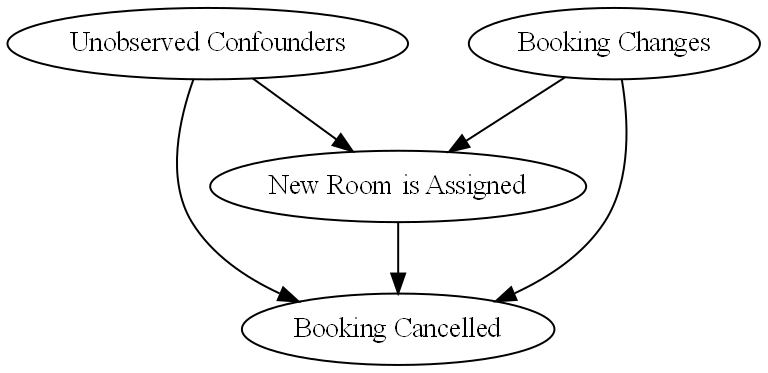

In [80]:
model = dowhy.CausalModel(
    data = hotel_1,
    graph = causal_graph.replace("\n", " "),
    treatment='AssignNewRoom',
    outcome='IsCanceled'
)
model.view_model()
display(Image(filename="causal_model.png"))

This is a very simple model with only one observed confounder. More complex models can be developed further.

**Causal Identification with Backdoor Adjustment:**

In [77]:
# identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

